+ **NOTE**: This notebook is trained on Google Colaboratory

# Set-Up

## Downloading YOLO weights

In [1]:
import os
os.mkdir('/tmp/weights/')
!wget https://pjreddie.com/media/files/yolov3.weights -O '/tmp/weights/yolov3.weights'
# !wget https://pjreddie.com/media/files/yolov3-tiny.weights -O '/tmp/weights/yolov3-tiny.weights'

--2020-05-09 15:40:04--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘/tmp/weights/yolov3.weights’

/tmp/weights/yolov3 100%[===================>] 236.52M   350KB/s    in 10m 42s 

2020-05-09 15:50:48 (377 KB/s) - ‘/tmp/weights/yolov3.weights’ saved [248007048/248007048]



In [0]:
weightfile = '/tmp/weights/yolov3.weights'

## Loading paths for other files

In [0]:
# loading coco labels
class_name = '/content/drive/My Drive/Colab Notebooks/coco.names'

# loading image
img_filename = "/content/drive/My Drive/Colab Notebooks/test.jpg"

# loading yolov3 configuration file
cfgfile = '/content/drive/My Drive/Colab Notebooks/yolov3.cfg'

# loading yolov3-tiny configuration file
# cfgfile_tiny = '/content/drive/My Drive/Colab Notebooks/yolov3-tiny.cfg'

## Setting some variables

In [0]:
model_size = (416, 416, 3)
num_classes = 80
max_output_size = 40
max_output_size_per_class= 20
iou_threshold = 0.5
confidence_threshold = 0.5

# Using TensorFlow

+ Reference: https://github.com/RahmadSadli/Deep-Learning/tree/master/YOLOv3_TF2

In [0]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Input, ZeroPadding2D, LeakyReLU, UpSampling2D

import numpy as np

import cv2
import time

In [0]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if(physical_devices!=[]):
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## yolov3.py

In [0]:
def parse_cfg(cfgfile):
    with open(cfgfile, 'r') as file:
        lines = [line.rstrip('\n') for line in file if line != '\n' and line[0] != '#']
    holder = {}
    blocks = []
    for line in lines:
        if line[0] == '[':
            line = 'type=' + line[1:-1].rstrip()
            if len(holder) != 0:
                blocks.append(holder)
                holder = {}
        key, value = line.split("=")
        holder[key.rstrip()] = value.lstrip()
    blocks.append(holder)
    return blocks

In [0]:
def YOLOv3Net(cfgfile, model_size, num_classes):

    blocks = parse_cfg(cfgfile)

    outputs = {}
    output_filters = []
    filters = []
    out_pred = []
    scale = 0

    inputs = input_image = Input(shape=model_size)
    inputs = inputs / 255.0

    for i, block in enumerate(blocks[1:]):
        # If it is a convolutional layer
        if (block["type"] == "convolutional"):

            activation = block["activation"]
            filters = int(block["filters"])
            kernel_size = int(block["size"])
            strides = int(block["stride"])

            if strides > 1:
                inputs = ZeroPadding2D(((1, 0), (1, 0)))(inputs)

            inputs = Conv2D(filters,
                            kernel_size,
                            strides=strides,
                            padding='valid' if strides > 1 else 'same',
                            name='conv_' + str(i),
                            use_bias=False if ("batch_normalize" in block) else True)(inputs)

            if "batch_normalize" in block:
                inputs = BatchNormalization(name='bnorm_' + str(i))(inputs)
            if activation == "leaky":
                inputs = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(inputs)

        elif (block["type"] == "upsample"):
            stride = int(block["stride"])
            inputs = UpSampling2D(stride)(inputs)

        # If it is a route layer
        elif (block["type"] == "route"):
            block["layers"] = block["layers"].split(',')
            start = int(block["layers"][0])

            if len(block["layers"]) > 1:
                end = int(block["layers"][1]) - i
                filters = output_filters[i + start] + output_filters[end]  # Index negatif :end - index
                inputs = tf.concat([outputs[i + start], outputs[i + end]], axis=-1)
            else:
                filters = output_filters[i + start]
                inputs = outputs[i + start]

        elif block["type"] == "shortcut":
            from_ = int(block["from"])
            inputs = outputs[i - 1] + outputs[i + from_]

        # Yolo detection layer
        elif block["type"] == "yolo":

            mask = block["mask"].split(",")
            mask = [int(x) for x in mask]
            anchors = block["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in mask]

            n_anchors = len(anchors)

            out_shape = inputs.get_shape().as_list()

            inputs = tf.reshape(inputs, [-1, n_anchors * out_shape[1] * out_shape[2], 5 + num_classes])

            box_centers = inputs[:, :, 0:2]
            box_shapes = inputs[:, :, 2:4]
            confidence = inputs[:, :, 4:5]
            classes = inputs[:, :, 5:num_classes + 5]

            box_centers = tf.sigmoid(box_centers)
            confidence = tf.sigmoid(confidence)
            classes = tf.sigmoid(classes)

            anchors = tf.tile(anchors, [out_shape[1] * out_shape[2], 1])
            box_shapes = tf.exp(box_shapes) * tf.cast(anchors, dtype=tf.float32)

            x = tf.range(out_shape[1], dtype=tf.float32)
            y = tf.range(out_shape[2], dtype=tf.float32)

            cx, cy = tf.meshgrid(x, y)
            cx = tf.reshape(cx, (-1, 1))
            cy = tf.reshape(cy, (-1, 1))
            cxy = tf.concat([cx, cy], axis=-1)
            cxy = tf.tile(cxy, [1, n_anchors])
            cxy = tf.reshape(cxy, [1, -1, 2])

            strides = (input_image.shape[1] // out_shape[1], \
                       input_image.shape[2] // out_shape[2])
            box_centers = (box_centers + cxy) * strides

            prediction = tf.concat([box_centers, box_shapes, confidence, classes], axis=-1)

            if scale:
                out_pred = tf.concat([out_pred, prediction], axis=1)
            else:
                out_pred = prediction
                scale = 1

        outputs[i] = inputs
        output_filters.append(filters)

    model = Model(input_image, out_pred)
    model.summary()
    return model

## convert_weights.py

In [0]:
def load_weights(model, cfgfile, weightfile):
    # Open the weights file
    fp = open(weightfile, "rb")

    # Skip 5 header values
    np.fromfile(fp, dtype=np.int32, count=5)

    # The rest of the values are the weights
    blocks = parse_cfg(cfgfile)

    for i, block in enumerate(blocks[1:]):

        if (block["type"] == "convolutional"):
            conv_layer = model.get_layer('conv_' + str(i))
            print("layer: ",i+1,conv_layer)

            filters = conv_layer.filters
            k_size = conv_layer.kernel_size[0]
            in_dim = conv_layer.input_shape[-1]

            if "batch_normalize" in block:
                norm_layer = model.get_layer('bnorm_' + str(i))
                print("layer: ",i+1,norm_layer)
                size = np.prod(norm_layer.get_weights()[0].shape)

                bn_weights = np.fromfile(fp, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            else:
                conv_bias = np.fromfile(fp, dtype=np.float32, count=filters)

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, k_size, k_size)
            conv_weights = np.fromfile(
                fp, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if "batch_normalize" in block:
                norm_layer.set_weights(bn_weights)
                conv_layer.set_weights([conv_weights])
            else:
                conv_layer.set_weights([conv_weights, conv_bias])

    assert len(fp.read()) == 0, 'failed to read all data'
    fp.close()

In [11]:
model = YOLOv3Net(cfgfile, model_size, num_classes)
load_weights(model, cfgfile, weightfile)

try:
    model.save_weights('/tmp/weights/yolov3_weights.tf')
    weightfile = '/tmp/weights/yolov3_weights.tf'
    print('\nThe file \'yolov3_weights.tf\' has been saved successfully.')
except IOError:
    print("Couldn't write the file \'yolov3_weights.tf\'.")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 416, 416, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         tf_op_layer_RealDiv[0][0]        
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
______________________________________________________________________________________________

## utils.py

In [0]:
def resize_image(inputs, modelsize):
    inputs= tf.image.resize(inputs, modelsize)
    return inputs

In [0]:
def output_boxes(inputs,model_size, max_output_size, max_output_size_per_class,
                 iou_threshold, confidence_threshold):

    center_x, center_y, width, height, confidence, classes = \
        tf.split(inputs, [1, 1, 1, 1, 1, -1], axis=-1)

    top_left_x = center_x - width / 2.0
    top_left_y = center_y - height / 2.0
    bottom_right_x = center_x + width / 2.0
    bottom_right_y = center_y + height / 2.0

    inputs = tf.concat([top_left_x, top_left_y, bottom_right_x,
                        bottom_right_y, confidence, classes], axis=-1)

    boxes_dicts = non_max_suppression(inputs, model_size, max_output_size,
                                      max_output_size_per_class, iou_threshold, confidence_threshold)

    return boxes_dicts

In [0]:
def draw_outputs(img, boxes, objectness, classes, nums, class_names):
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    boxes=np.array(boxes)

    for i in range(nums):
        x1y1 = tuple((boxes[i,0:2] * [img.shape[1],img.shape[0]]).astype(np.int32))
        x2y2 = tuple((boxes[i,2:4] * [img.shape[1],img.shape[0]]).astype(np.int32))

        img = cv2.rectangle(img, (x1y1), (x2y2), (255,0,0), 2)

        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
                          (x1y1), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)
    return img

In [0]:
def load_class_names(file_name):
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names

In [0]:
def non_max_suppression(inputs, model_size, max_output_size,
                        max_output_size_per_class, iou_threshold, confidence_threshold):
    bbox, confs, class_probs = tf.split(inputs, [4, 1, -1], axis=-1)
    bbox=bbox/model_size[0]

    scores = confs * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=max_output_size_per_class,
        max_total_size=max_output_size,
        iou_threshold=iou_threshold,
        score_threshold=confidence_threshold
    )
    return boxes, scores, classes, valid_detections

## image.py

In [0]:
def image():

    model = YOLOv3Net(cfgfile,model_size,num_classes)
    model.load_weights(weightfile)

    class_names = load_class_names(class_name)

    image = cv2.imread(img_filename)
    image = np.array(image)
    image = tf.expand_dims(image, 0)

    resized_frame = resize_image(image, (model_size[0],model_size[1]))
    pred = model.predict(resized_frame)

    boxes, scores, classes, nums = output_boxes( \
        pred, model_size,
        max_output_size=max_output_size,
        max_output_size_per_class=max_output_size_per_class,
        iou_threshold=iou_threshold,
        confidence_threshold=confidence_threshold)

    image = np.squeeze(image)
    img = draw_outputs(image, boxes, scores, classes, nums, class_names)

    win_name = 'Image detection'
    # cv2.imshow(win_name, img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    from google.colab.patches import cv2_imshow
    cv2_imshow(img)

    #If you want to save the result, uncommnent the line below:
    cv2.imwrite('/tmp/test.jpg', img)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv_1 (TensorFl [(None, 416, 416, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         tf_op_layer_RealDiv_1[0][0]      
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
____________________________________________________________________________________________

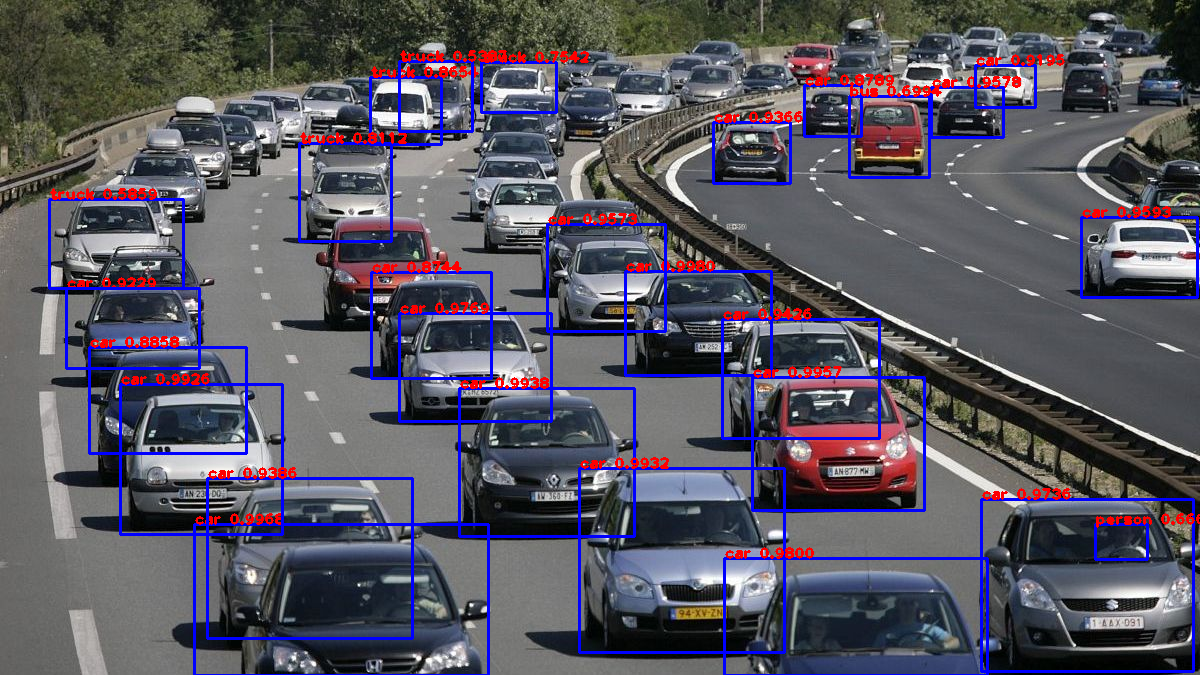

In [18]:
image()

## video.py

In [0]:
def video():

    model = YOLOv3Net(cfgfile, model_size, num_classes)

    model.load_weights(weightfile)

    class_names = load_class_names(class_name)



    win_name = 'Yolov3 detection'
    cv2.namedWindow(win_name)

    #specify the vidoe input.
    # 0 means input from cam 0.
    # For vidio, just change the 0 to video path
    cap = cv2.VideoCapture(0)
    frame_size = (cap.get(cv2.CAP_PROP_FRAME_WIDTH),
                  cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    try:
        while True:
            start = time.time()
            ret, frame = cap.read()
            if not ret:
                break

            resized_frame = tf.expand_dims(frame, 0)
            resized_frame = resize_image(resized_frame, (model_size[0],model_size[1]))

            pred = model.predict(resized_frame)

            boxes, scores, classes, nums = output_boxes( \
                pred, model_size,
                max_output_size=max_output_size,
                max_output_size_per_class=max_output_size_per_class,
                iou_threshold=iou_threshold,
                confidence_threshold=confidence_threshold)

            img = draw_outputs(frame, boxes, scores, classes, nums, class_names)
            cv2.imshow(win_name, img)

            stop = time.time()

            seconds = stop - start
            # print("Time taken : {0} seconds".format(seconds))

            # Calculate frames per second
            fps = 1 / seconds
            print("Estimated frames per second : {0}".format(fps))

            key = cv2.waitKey(1) & 0xFF

            if key == ord('q'):
                break

    finally:
        cv2.destroyAllWindows()
        cap.release()
        print('Detections have been performed successfully.')

In [0]:
# video()

# Using OpenCV

+ Reference: https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/

In [0]:
import cv2
import time
import numpy as np

In [0]:
def load_class_names(file_name):
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names

LABELS = load_class_names(class_name)

In [0]:
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

In [0]:
net = cv2.dnn.readNetFromDarknet(cfgfile, weightfile)

In [10]:
# load our input image and grab its spatial dimensions
image = cv2.imread(img_filename)
(H, W) = image.shape[:2]

# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)

start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 2.416741 seconds


In [0]:
# initialize our lists of detected bounding boxes, confidences, and class IDs, respectively
boxes = []
confidences = []
classIDs = []

In [0]:
# loop over each of the layer outputs
for output in layerOutputs:

	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]

		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > confidence_threshold:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
   
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
   
			# update our list of bounding box coordinates, confidences, and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

In [0]:
# apply non-maxima suppression to suppress weak, overlapping bounding boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, iou_threshold)

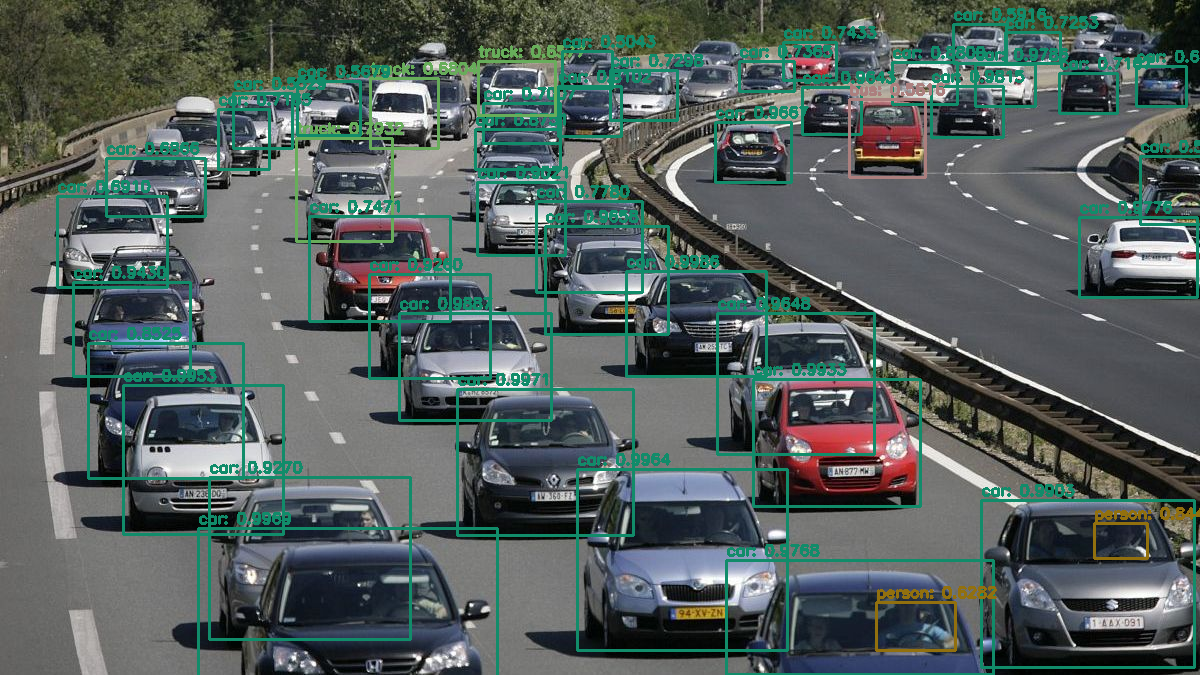

In [28]:
# ensure at least one detection exists
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
  
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
  
# show the output image
# cv2.imshow("Image", image)
# cv2.waitKey(0)
from google.colab.patches import cv2_imshow
cv2_imshow(image)